In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
xr.set_options(keep_attrs=True)
import sys
sys.path.insert(1, '/glade/u/home/lettier/analysis/')
import master_utils as myf
import matplotlib.path as mpath
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

In [2]:
mydir = '/glade/work/lettier/NUDGE/processed/spatial_mean_trend/atm/'
myfiles = [mydir+f for f in sorted(os.listdir(mydir)) if 'atm_climtrend.1979' in f and 'zonal' not in f and ('LENS' in f or '60' in f or 'ERAI' in f)]
mynames = sorted(list(set([f.split('.')[0].split('/')[-1] for f in myfiles])))

In [3]:
listds = []
for file in myfiles: 
        ds = xr.open_dataset(file)
        ds = ds.set_coords('names')
        if 'lev' in ds:
            ds = ds.drop('lev')
        listds.append(ds)
ds = xr.concat(listds,dim='names')

In [4]:
myfiles = [mydir+f for f in sorted(os.listdir(mydir)) if 'Z3' in f]
listds = []
for file in myfiles: 
        gphds = xr.open_dataset(file)
        listds.append(gphds)
gphds = xr.concat(listds,dim='names')
gphds['season'] = ['DJF','MAM','JJA','SON']

In [5]:
ds = xr.merge([ds, 
gphds.T_trend.sel(plev=200).to_dataset(name='T200_trend').drop('plev'), gphds.T_p_value.sel(plev=200).to_dataset(name='T200_p_value').drop('plev'),
gphds.T_trend.sel(plev=500).to_dataset(name='T500_trend').drop('plev'), gphds.T_p_value.sel(plev=500).to_dataset(name='T500_p_value').drop('plev'),
gphds.Z3_trend.sel(plev=200).to_dataset(name='Z200_trend').drop('plev'), gphds.Z3_p_value.sel(plev=200).to_dataset(name='Z200_p_value').drop('plev'),
gphds.Z3_trend.sel(plev=500).to_dataset(name='Z500_trend').drop('plev'), gphds.Z3_p_value.sel(plev=500).to_dataset(name='Z500_p_value').drop('plev')])


In [6]:
thelens = [f for f in ds.names.values if 'LENS' in f]
lensmean = ds.isel(names=0).copy()
for var in ds:
    lensmean[var] = ds[var].sel(names=thelens).mean(dim='names')
lensmean['names'] = 'LENSmean'
lensmean =lensmean.set_coords('names')

In [7]:
thenudge = ['anom_nudge_era_60','anom_nudge_era_60_arclo','anom_nudge_era_60_archi']
a60nudgemean = ds.isel(names=0).copy()
for var in ds:
    a60nudgemean[var] = ds[var].sel(names=thenudge).mean(dim='names')
a60nudgemean['names'] = 'aNUDGEmean'
a60nudgemean = a60nudgemean.set_coords('names')

In [8]:
ds = xr.concat([ds, lensmean, a60nudgemean],dim='names')

In [9]:
mydict = {}
mydict['TREFHT_trend'] = {'levels' : 10.*np.arange(-.2,.22,.02), 'cmap' : plt.cm.RdBu_r,'label':'Trend in 2m air temperature (K/decade)' }
mydict['T200_trend'] = {'levels' : 10.*np.arange(-.1,.11,.01), 'cmap' : plt.cm.RdBu_r  ,'label':'Trend in 200m air temperature (K/decade)'}
mydict['T500_trend'] = {'levels' : 10.*np.arange(-.1,.11,.01), 'cmap' : plt.cm.RdBu_r  ,'label':'Trend in 500m air temperature (K/decade)'}
mydict['U_trend'] = {'levels' : 10.*np.arange(-.08,.08+.01,.01), 'cmap' : plt.cm.PRGn  ,'label':'Trend in surface U wind (m s$^{-1}$/decade)'}
mydict['V_trend'] = {'levels' : 10.*np.arange(-.08,.08+.01,.01), 'cmap' : plt.cm.PRGn  ,'label':'Trend in surface V wind (m s$^{-1}$/decade)'}
mydict['windspeed_trend'] = {'levels' : 10.*np.arange(-.04,.04+.005,.005), 'cmap' : plt.cm.PRGn  ,'label':'Trend in surface wind speed (m s$^{-1}$/decade)'}

mydict['PS_trend'] = {'levels' : 10.*np.arange(-20,22,2), 'cmap' : plt.cm.BrBG,'label':'Trend in surface pressure (Pa/decade)'}
mydict['Z200_trend'] = {'levels' : np.arange(-30,33,3), 'cmap' : plt.cm.PiYG,'label':'Trend in Z200 (m/decade)'}
mydict['Z500_trend'] = {'levels' : np.arange(-20,22,2), 'cmap' : plt.cm.PiYG,'label':'Trend in Z500 (m/decade)'}


In [10]:
mynames = ['ERAI','LENSmean','aNUDGEmean'] 

In [11]:
myvars = [f for f in ds if 'trend' in f]

In [12]:
myf.alphabet

['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']

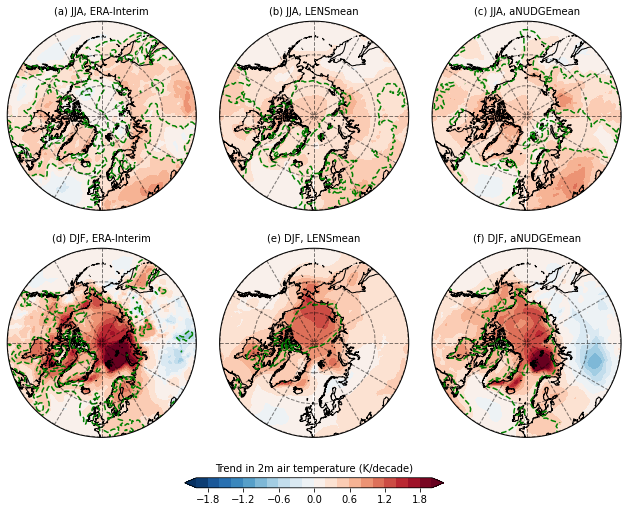

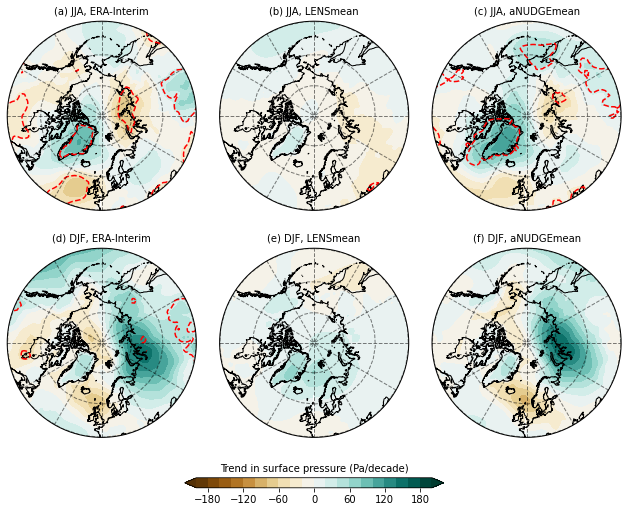

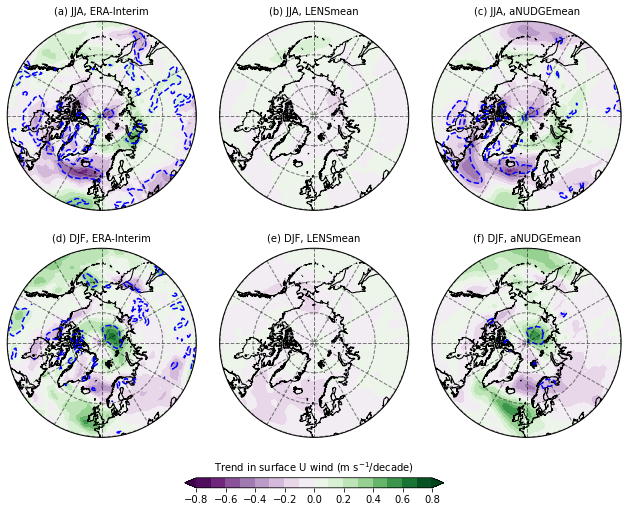

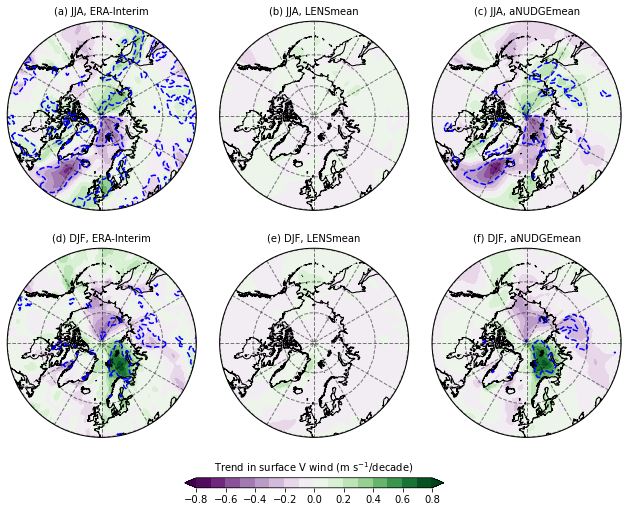

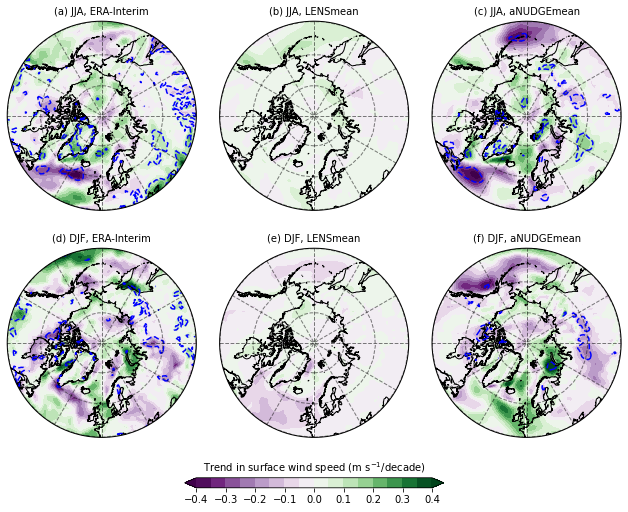

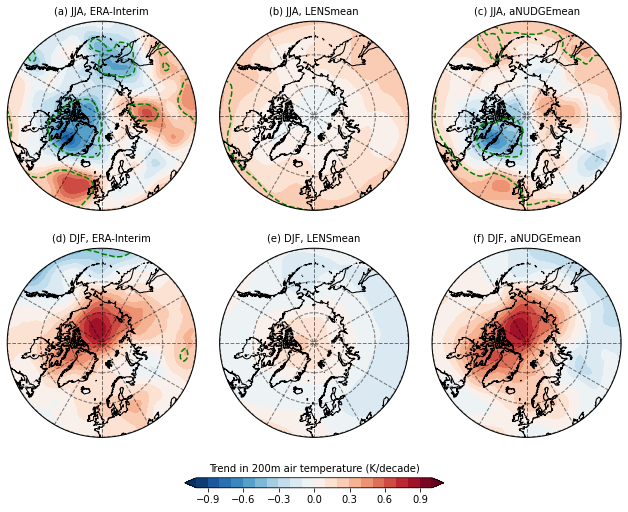

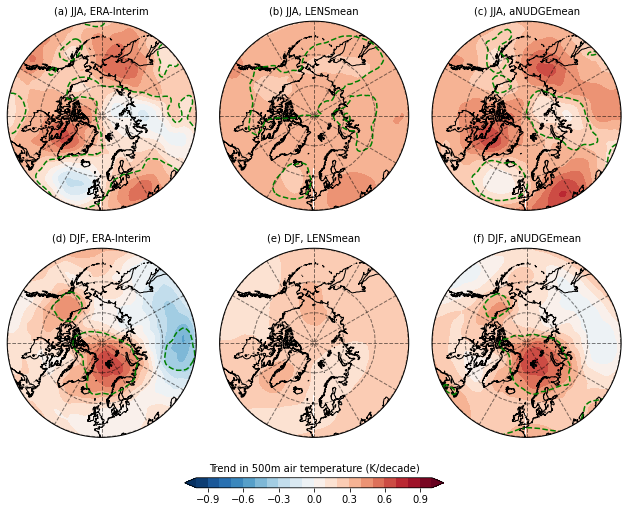

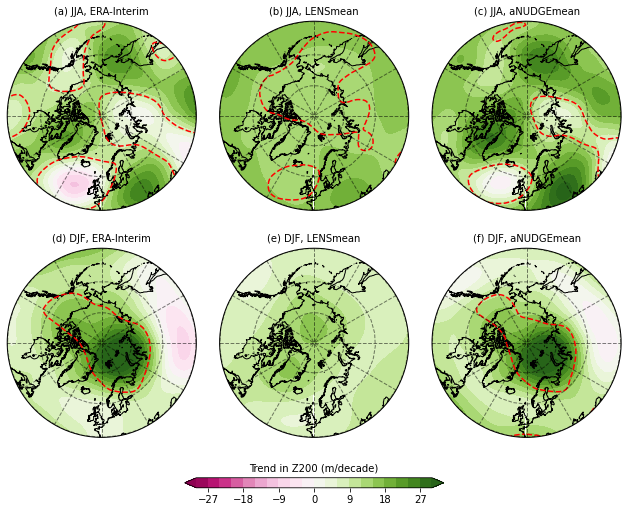

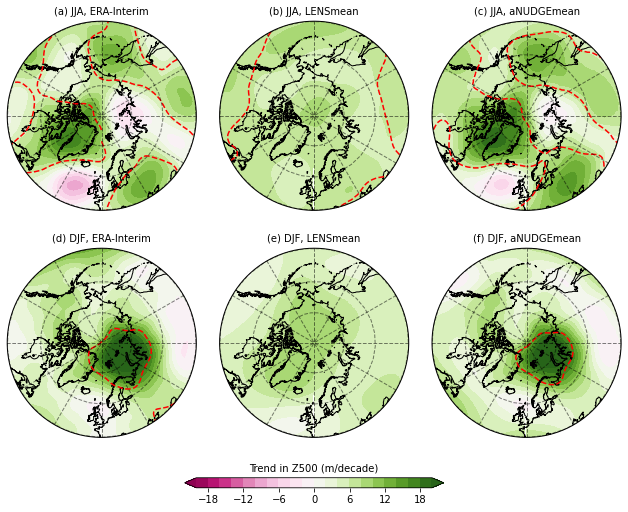

In [13]:
for v, var in enumerate(myvars):


    fig = plt.figure(figsize=(3*len(mynames),7))
    for ct, seas in enumerate(['JJA','DJF']):
        for n, name in enumerate(mynames):
            ax = plt.subplot(2,len(mynames),ct*len(mynames)+n+1, projection = ccrs.NorthPolarStereo())
            ax.set_extent([0.005, 360, 45, 90], crs=ccrs.PlateCarree())
            label = myf.alphabet[ct*len(mynames)+n]
            ax.set_title(str(label)+' '+seas+', '+['ERA-Interim','LENSmean','aNUDGEmean'][n],fontsize=10,loc='center')
             
            dmeridian = 30  # spacing for lines of meridian
            dparallel = 15  # spacing for lines of parallel 
            num_merid = int(360/dmeridian + 1)
            num_parra = int(90/dparallel + 1)
            gl = ax.gridlines(crs=ccrs.PlateCarree(), \
                              xlocs=np.linspace(0, 360, num_merid), \
                              ylocs=np.linspace(0, 90, num_parra), \
                              linestyle="--", linewidth=1, color='k', alpha=0.5)

            theta = np.linspace(0, 2*np.pi, 120)
            verts = np.vstack([np.sin(theta), np.cos(theta)]).T
            center, radius = [0.5, 0.5], 0.5
            circle = mpath.Path(verts * radius + center)

            ax.set_boundary(circle, transform=ax.transAxes)  #without this; get rect bound
            
            if np.nanmax(abs(10.*ds[var].sel(season=seas).sel(names=name).values ))>0:
                CS1 = ax.contourf(ds.lon,ds.lat, 10.*ds[var].sel(season=seas).sel(names=name).values , **mydict[var], transform=ccrs.PlateCarree(), extend='both')
       
            ax.contour(ds.lon,ds.lat, ds[var.split('_')[0]+'_p_value'].sel(season=seas).sel(names=name), levels = [5.], transform=ccrs.PlateCarree(),
                       colors=['g','r','b','b','b','g','g','r','r'][v],linestyles=['--'])
            ax.coastlines("50m")   
                     
    plt.tight_layout()
    plt.subplots_adjust(hspace=.2, bottom = .15)
    cbar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.02]) #[left, bottom, width, height]
    cbar = fig.colorbar(CS1, cax=cbar_ax,  orientation='horizontal')
    cbar.ax.set_title(mydict[var]['label'],fontsize=10)
    fig.savefig('figs/'+var+'.pdf', dpi=500, bbox_inches='tight')
    plt.show()
    plt.close()

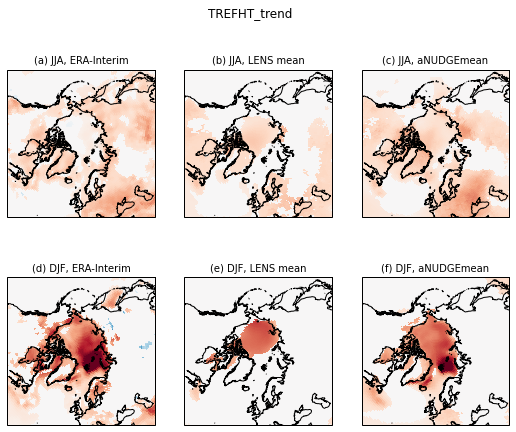

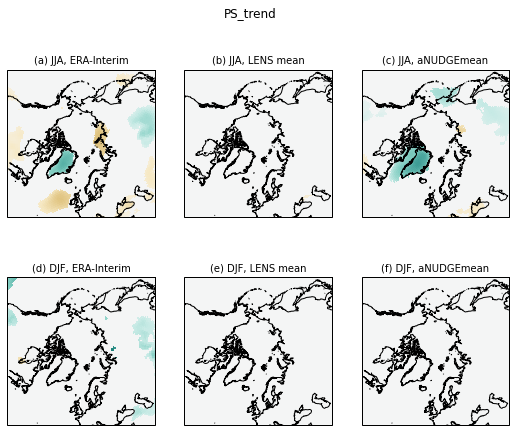

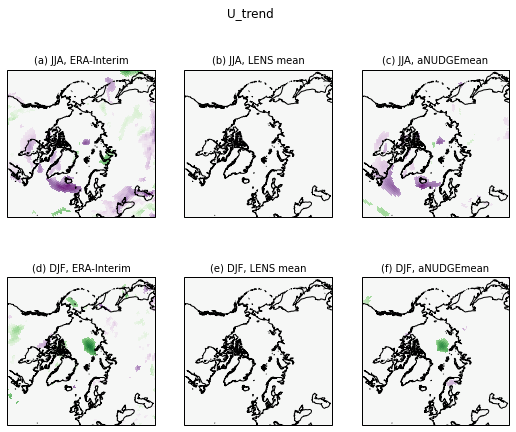

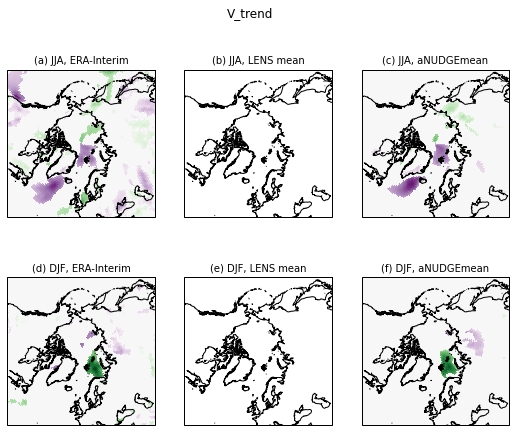

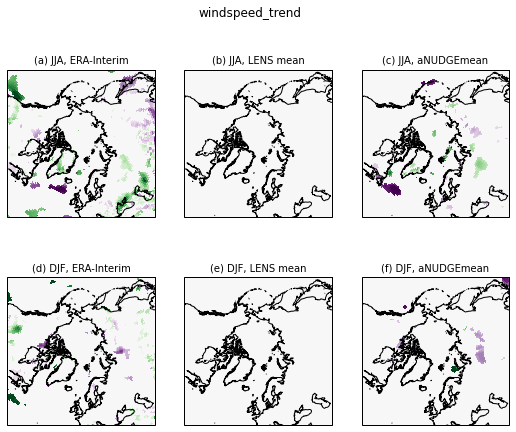

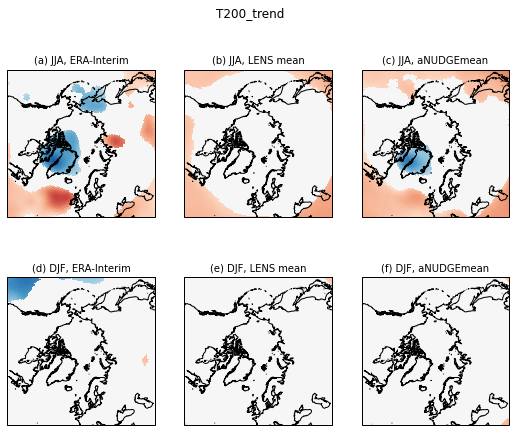

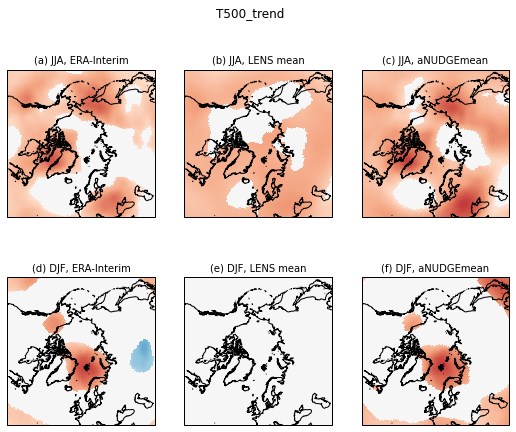

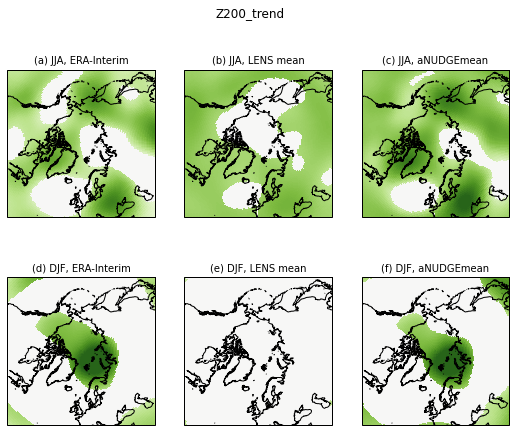

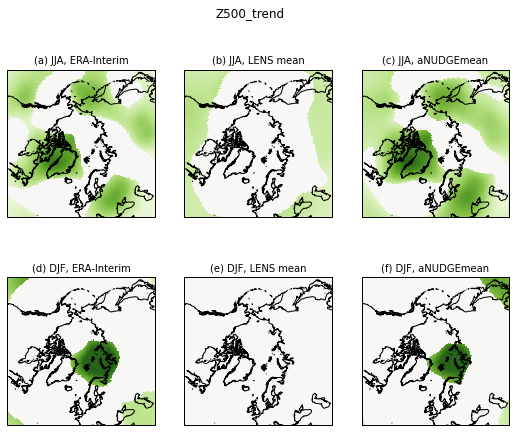

In [14]:
for v, var in enumerate(myvars):

    fig = plt.figure(figsize=(3*len(mynames),7))
    for ct, seas in enumerate(['JJA','DJF']):
        for n, name in enumerate(mynames):
            ax = plt.subplot(2,len(mynames),ct*len(mynames)+n+1, projection = ccrs.NorthPolarStereo())
            ax.set_extent([0.005, 360, 45, 90], crs=ccrs.PlateCarree())
            label = ['a','b','c','d','e','f'][ct*len(mynames)+n]
            ax.set_title('('+str(label)+') '+seas+', '+['ERA-Interim','LENS mean','aNUDGEmean'][n],fontsize=10,loc='center')
             
            mydata = 10.*(ds[var].where(ds[var.split('_')[0]+'_p_value']<5.)).sel(season=seas).sel(names=name).values
            mydata = np.where(mydata!=mydata,0.,mydata)
            if np.max(abs(mydata))>0:
                CS1 = ax.pcolormesh(ds.lon,ds.lat, mydata, vmin = mydict[var]['levels'].min(), vmax = mydict[var]['levels'].max() , cmap =mydict[var]['cmap'], transform=ccrs.PlateCarree())
            ax.coastlines("50m")   
    plt.suptitle(var)
    plt.tight_layout()
    plt.show()
    plt.close()

## Now plot sea ice concentration

In [15]:
mydir = '/glade/work/lettier/NUDGE/processed/spatial_mean_trend/ice/aice/'
myfiles = [mydir+f for f in sorted(os.listdir(mydir)) if 'aice_climtrend' in f]
mynames = sorted(list(set([f.split('.')[0].split('/')[-1] for f in myfiles])))

myd = '/glade/scratch/lettier/AGU/'
obds = xr.open_dataset(myd+'seaice_conc_monthly_nh_1979-2018_remapcesmgrid.nc').isel(time=0)
obds = obds.sel(nj=slice(-104,None))


In [16]:
listds = []
for file in myfiles: 
    name = file.split('/')[-1].split('.')[0]
    if '_nh' in name:
        name = name[:-3]
    
    sicds = xr.open_mfdataset(file).sel(nj=slice(-104,None))[['aice_trend','aice_clim','aice_p_value']] 
    sicds['names'] = name
    sicds = sicds.set_coords('names')
    
    listds.append(sicds)
sicds = xr.concat(listds,dim='names')

In [17]:
mydir = '/glade/work/lettier/NUDGE/processed/spatial_mean_trend/ice/hi/'
myfiles = [mydir+f for f in sorted(os.listdir(mydir)) if 'hi_climtrend' in f]
mynames = sorted(list(set([f.split('.')[0].split('/')[-1] for f in myfiles])))

listds = []
for file in myfiles: 
    name = file.split('/')[-1].split('.')[0]
    if '_nh' in name:
        name = name[:-3]
    
    sitds = xr.open_mfdataset(file).sel(nj=slice(-104,None))[['hi_trend','hi_clim','hi_p_value']] 
    sitds['names'] = name
    sitds = sitds.set_coords('names')
    
    listds.append(sitds)
sitds = xr.concat(listds,dim='names')
sicds = xr.merge([sicds,sitds])

In [18]:
sicds['TLAT'] = sicds['TLAT'].isel(names=0)
sicds['TLON'] = sicds['TLON'].isel(names=0)
sicds['TLAT'].values = obds.TLAT
sicds['TLON'].values = obds.TLON

In [19]:
thelens = [f for f in sicds.names.values if 'LENS' in f]
lensmean = sicds.isel(names=0).copy()
for var in sicds:
    lensmean[var] = sicds[var].sel(names=thelens).mean(dim='names')
lensmean['names'] = 'LENSmean'
lensmean = lensmean.set_coords('names')

In [20]:
thenudge = ['anom_nudge_era_60','anom_nudge_era_60_archi','anom_nudge_era_60_arclo']
a60nudgemean = sicds.isel(names=0).copy()
for var in sicds:
    a60nudgemean[var] = sicds[var].sel(names=thenudge).mean(dim='names')
a60nudgemean['names'] = 'aNUDGEmean'
a60nudgemean = a60nudgemean.set_coords('names')

In [21]:
sicds = xr.concat([sicds.sel(names='OBS-merged-remap'),lensmean,a60nudgemean],dim='names')

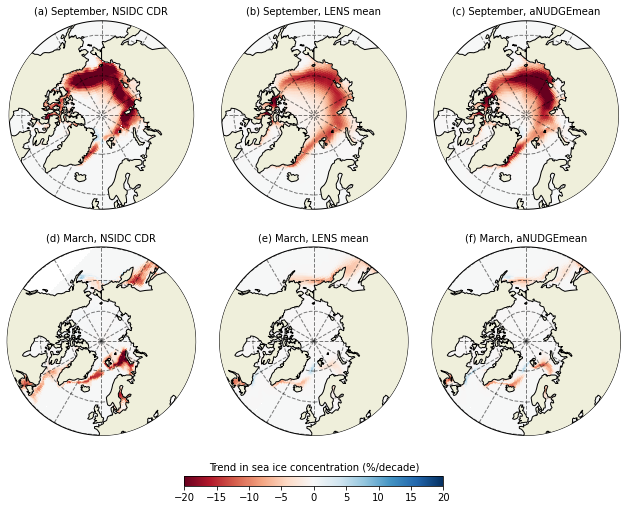

In [22]:
mynames = ['OBS-merged-remap', 'LENSmean','aNUDGEmean']

fig = plt.figure(figsize=(3*len(mynames),7))
for ct, month in enumerate([9,3]):
    for n, name in enumerate(mynames):

        ax = plt.subplot(2,len(mynames),ct*len(mynames)+n+1,projection =ccrs.NorthPolarStereo())
        ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
        ax.set_extent([0.005, 360, [55,45][ct], 90], crs=ccrs.PlateCarree())
        label = ['a','b','c','d','e','f'][ct*len(mynames)+n]
        ax.set_title('('+str(label)+') '+['September','March'][ct]+', '+['NSIDC CDR','LENS mean','aNUDGEmean'][n],fontsize=10,loc='center')

        dmeridian = 30  # spacing for lines of meridian
        dparallel = 15  # spacing for lines of parallel 
        num_merid = int(360/dmeridian + 1)
        num_parra = int(90/dparallel + 1)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), \
                          xlocs=np.linspace(0, 360, num_merid), \
                          ylocs=np.linspace(0, 90, num_parra), \
                          linestyle="--", linewidth=1, color='k', alpha=0.5)

        theta = np.linspace(0, 2*np.pi, 120)
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        center, radius = [0.5, 0.5], 0.5
        circle = mpath.Path(verts * radius + center)
        ax.set_boundary(circle, transform=ax.transAxes)  #without this; get rect bound

        CS1 = ax.pcolormesh(sicds.TLON, sicds.TLAT, 10.*sicds.aice_trend.sel(names=name).sel(month=month),
                            cmap = plt.cm.RdBu, transform=ccrs.PlateCarree(),vmin=-20,vmax=20) 
       
        
plt.tight_layout()
plt.subplots_adjust(hspace=.2, bottom = .15)
cbar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.02]) #[left, bottom, width, height]

cbar = fig.colorbar(CS1, cax=cbar_ax,  orientation='horizontal')
cbar.ax.set_title(r'Trend in sea ice concentration (%/decade)',fontsize=10)


fig.savefig('figs/sic_trend.pdf', dpi=500, bbox_inches='tight')
plt.show()
plt.close()

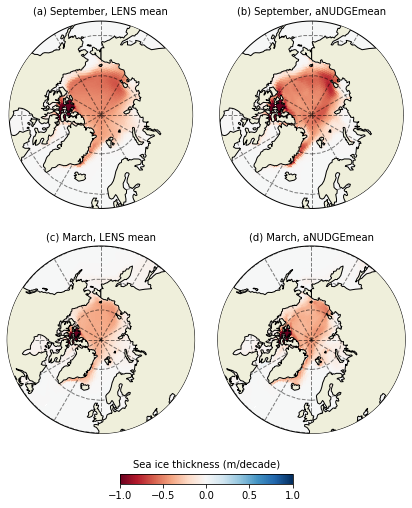

In [23]:
mynames = ['LENSmean','aNUDGEmean']

fig = plt.figure(figsize=(3*len(mynames),7))
for ct, month in enumerate([9,3]):
    for n, name in enumerate(mynames):

        ax = plt.subplot(2,len(mynames),ct*len(mynames)+n+1,projection =ccrs.NorthPolarStereo())
        ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
        ax.set_extent([0.005, 360, [55,45][ct], 90], crs=ccrs.PlateCarree())
        label = ['a','b','c','d','e','f'][ct*len(mynames)+n]
        ax.set_title('('+str(label)+') '+['September','March'][ct]+', '+['LENS mean','aNUDGEmean'][n],fontsize=10,loc='center')

        dmeridian = 30  # spacing for lines of meridian
        dparallel = 15  # spacing for lines of parallel 
        num_merid = int(360/dmeridian + 1)
        num_parra = int(90/dparallel + 1)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), \
                          xlocs=np.linspace(0, 360, num_merid), \
                          ylocs=np.linspace(0, 90, num_parra), \
                          linestyle="--", linewidth=1, color='k', alpha=0.5)

        theta = np.linspace(0, 2*np.pi, 120)
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        center, radius = [0.5, 0.5], 0.5
        circle = mpath.Path(verts * radius + center)
        ax.set_boundary(circle, transform=ax.transAxes)  #without this; get rect bound

        CS1 = ax.pcolormesh(sicds.TLON, sicds.TLAT, 10.*sicds.hi_trend.sel(names=name).sel(month=month),
                            cmap = plt.cm.RdBu, transform=ccrs.PlateCarree(),vmin=-1,vmax=1) 
       
        
plt.tight_layout()
plt.subplots_adjust(hspace=.2, bottom = .15)
cbar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.02]) #[left, bottom, width, height]

cbar = fig.colorbar(CS1, cax=cbar_ax,  orientation='horizontal')
cbar.ax.set_title(r'Sea ice thickness (m/decade)',fontsize=10)


#fig.savefig('figs/sic_trend.pdf', dpi=500, bbox_inches='tight')
plt.show()
plt.close()

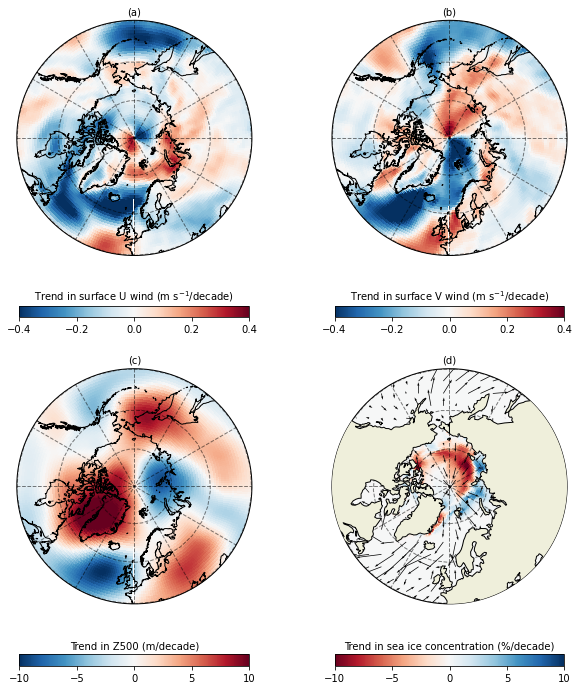

In [24]:
ds = ds.where(ds.lat>0.,drop=True)
 # have to do this for North Polar Stereo vector plots

diff = 10.*(ds.sel(names='aNUDGEmean') - ds.sel(names='LENSmean'))
sicdiff = 10.*(sicds.sel(names='aNUDGEmean') - sicds.sel(names='LENSmean'))



seas = 'JJA'
myvars = ['U_trend','V_trend','Z500_trend','aice_trend']#,'hi_trend']

fig = plt.figure(figsize=(10,10))
for v, var in enumerate(myvars):  
   
    ax = plt.subplot(2,2, v+1, projection = ccrs.NorthPolarStereo())
    ax.set_extent([0.005, 360, 45, 90], crs=ccrs.PlateCarree())
    ax.set_title(myf.alphabet[v],fontsize=10,loc='center')

    dmeridian = 30  # spacing for lines of meridian
    dparallel = 15  # spacing for lines of parallel 
    num_merid = int(360/dmeridian + 1)
    num_parra = int(90/dparallel + 1)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), \
                      xlocs=np.linspace(0, 360, num_merid), \
                      ylocs=np.linspace(0, 90, num_parra), \
                      linestyle="--", linewidth=1, color='k', alpha=0.5)

    theta = np.linspace(0, 2*np.pi, 120)
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    center, radius = [0.5, 0.5], 0.5
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)  #without this; get rect bound
    
    
    
    if var=='aice_trend': 
        CS1 = ax.pcolormesh(sicds.TLON, sicds.TLAT, sicdiff.aice_trend.sel(month=9),
                            cmap = plt.cm.RdBu, transform=ccrs.PlateCarree(),vmin=-10, vmax=10)
        ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
        
       
        Q = ax.quiver(ds.lon.values, ds.lat.values, diff.U_trend.sel(season=seas).values, diff.V_trend.sel(season=seas).values, 
                      transform=ccrs.PlateCarree(), regrid_shape=20 )

        cb = plt.colorbar(CS1,shrink=.6,orientation='horizontal')
        cb.ax.set_title(r'Trend in sea ice concentration (%/decade)',fontsize=10)
    elif var=='hi_trend': 
        CS1 = ax.pcolormesh(sicds.TLON, sicds.TLAT, sicdiff.hi_trend.sel(month=9),
                            cmap = plt.cm.RdBu, transform=ccrs.PlateCarree(),vmin=-val, vmax=val)
        ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
     
    else:
        val = 0.5*mydict[var]['levels'].max()
        CS1 = ax.pcolormesh(ds.lon,ds.lat, diff[var].sel(season=seas) , cmap = plt.cm.RdBu_r, 
                              transform=ccrs.PlateCarree(), vmin=-val, vmax=val )
        
        ax.coastlines("50m") 
        cb = plt.colorbar(CS1,shrink=.6,orientation='horizontal')
        cb.ax.set_title(mydict[var]['label'],fontsize=10)

                    
plt.tight_layout()
fig.savefig('figs/aNUDGEminusLENSmean_combo.pdf', dpi=500, bbox_inches='tight')
plt.show()
plt.close()

# Regressions with September sea ice extent trend

In [25]:
mydir = '/glade/work/lettier/NUDGE/processed/siasivsie/'
myfiles = [mydir+f for f in sorted(os.listdir(mydir))]
mynames = sorted(list(set([f.split('.')[0].split('/')[-1] for f in myfiles])))
listds = []
for name in mynames: 
    if 'OB' not in name:
        subfiles = [mydir+f for f in os.listdir(mydir) if name+'.' in f and f[0]==name[0]]
        sids = xr.open_mfdataset(subfiles)
        sids = sids.set_coords('names')
        listds.append(sids)
sids = xr.concat(listds,dim='names')

In [26]:
sie_nh = myf.xr_reshape(sids.sie_nh,'time',['year','month'],[np.arange(1979,2018+1),np.arange(1,13,1)])

In [27]:
siv_nh = myf.xr_reshape(sids.siv_nh,'time',['year','month'],[np.arange(1979,2018+1),np.arange(1,13,1)])

In [28]:
slope, intercept, r_value, p_value, std_err = myf.linregress(sie_nh.year, sie_nh.load(), dim='year')

In [29]:
slope_siv, intercept, r_value, p_value, std_err = myf.linregress(siv_nh.year, siv_nh.load(), dim='year')

In [30]:
lens_sie_trend_sep = slope.sel(names=[f for f in slope.names.values if 'LENS' in f]).sel(month=9)
lens_sie_trend_sep['names'] = [f for f in ds.names.values if 'LENS' in f and 'mean' not in f]

In [31]:
lens_siv_trend_sep = slope_siv.sel(names=[f for f in slope.names.values if 'LENS' in f]).sel(month=9)
lens_siv_trend_sep['names'] = [f for f in ds.names.values if 'LENS' in f and 'mean' not in f]

TREFHT_trend


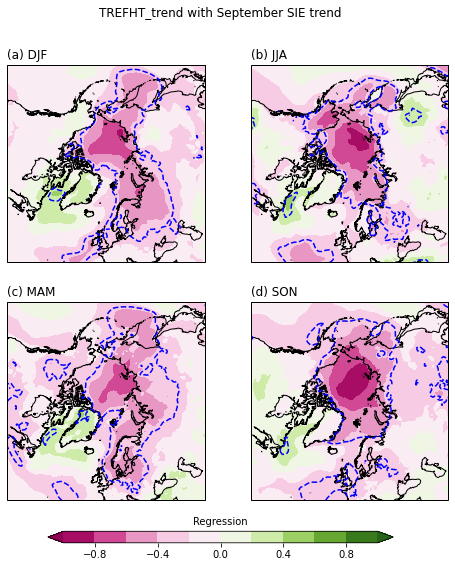

PS_trend


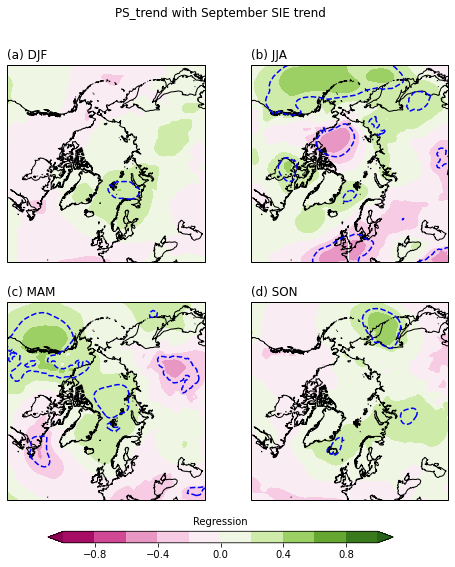

U_trend


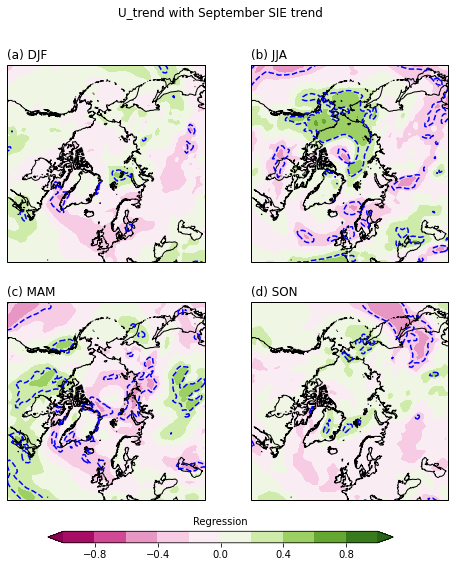

V_trend


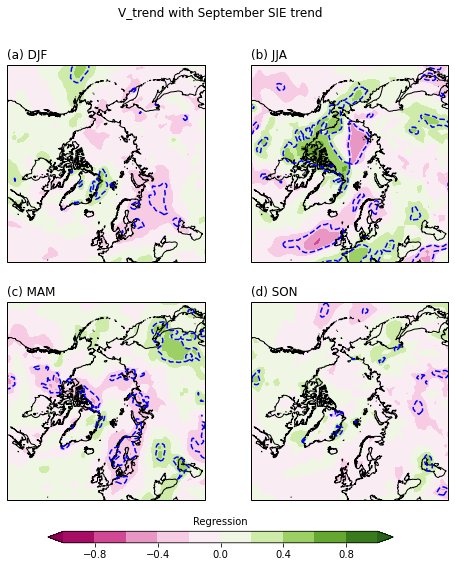

windspeed_trend


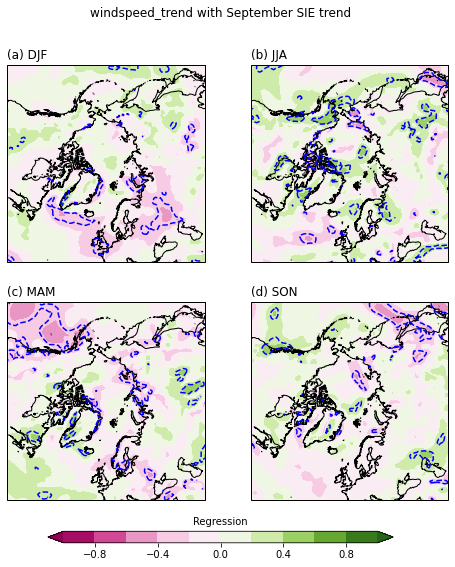

T200_trend


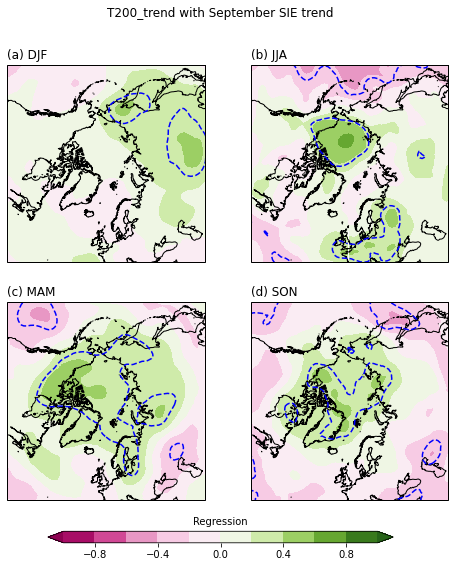

T500_trend


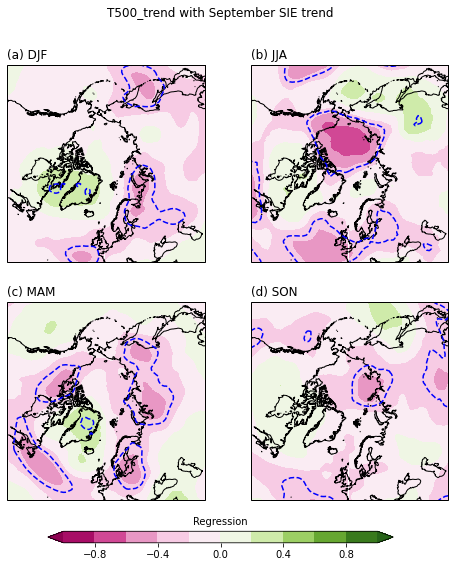

Z200_trend


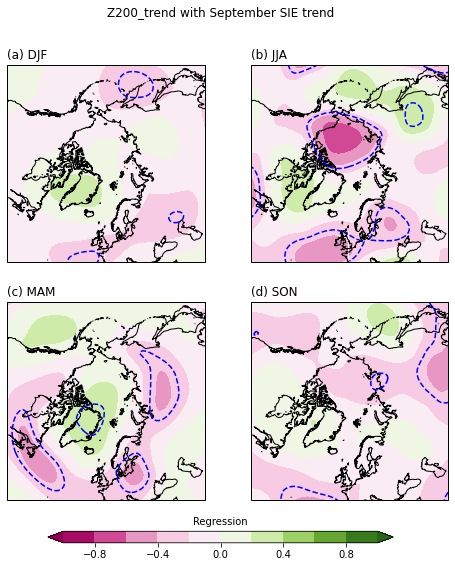

Z500_trend


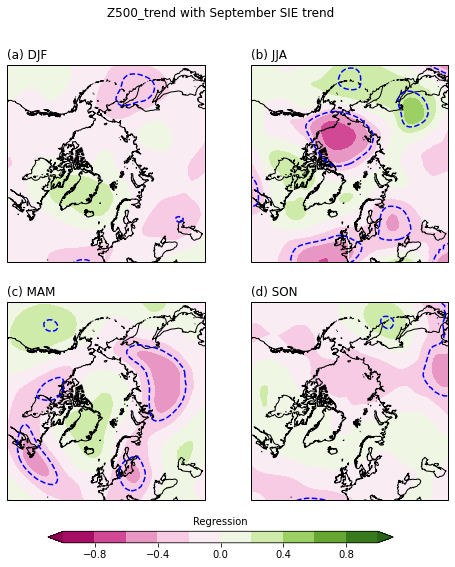

In [32]:
for var in ds:
    if 'trend' in var:
        print(var)
        xdata = ds[var].squeeze().sel(names = [f for f in ds.names.values if 'LEN' in f and 'mean' not in f])
        xdata = xdata.where(xdata==xdata,0.)
        corr, pval = myf.pearson(xdata, lens_sie_trend_sep, 'names')

        fig = plt.figure(figsize=(8,8))

        for s, seas in enumerate(ds.season.values):
            ax = plt.subplot(2,2,1+s, projection = ccrs.NorthPolarStereo())
            ax.set_extent([0.005, 360, 45, 90], crs=ccrs.PlateCarree())
            ax.coastlines("50m")  
            CS1 = ax.contourf(ds.lon,ds.lat, corr.sel(season=seas) ,
                          transform=ccrs.PlateCarree(), cmap = plt.cm.PiYG, extend='both',
                         levels = np.arange(-1,1.2,.2))

            ax.contour(ds.lon,ds.lat, pval.sel(season=seas) ,
                          transform=ccrs.PlateCarree(), levels=[.05], colors=['b'],linestyles=['--'])

            ax.set_title(myf.alphabet[s]+' '+seas,loc='left')
        cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02]) #[left, bottom, width, height]
        cbar = fig.colorbar(CS1, cax=cbar_ax,  orientation='horizontal')
        cbar.ax.set_title('Regression',fontsize=10)
        plt.suptitle(var+' with September SIE trend')
        plt.tight_layout()
        fig.savefig('figs/regression_'+var+'.pdf', dpi=500, bbox_inches='tight')
        plt.show()
        plt.close()

TREFHT_trend


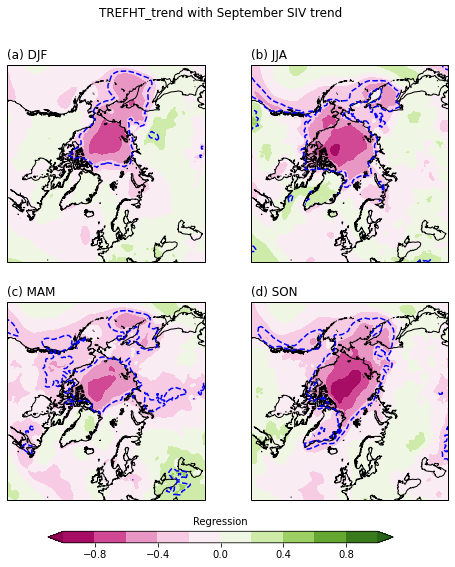

PS_trend


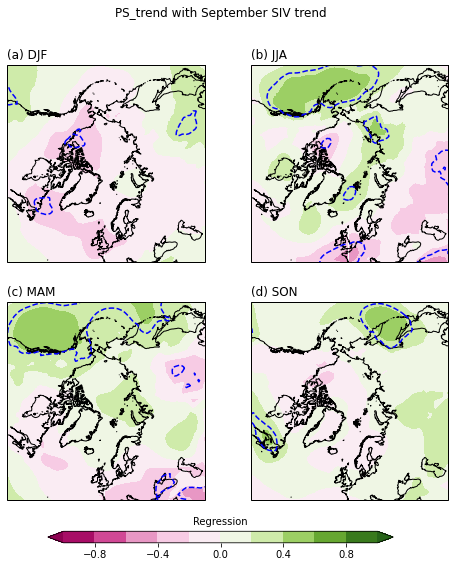

U_trend


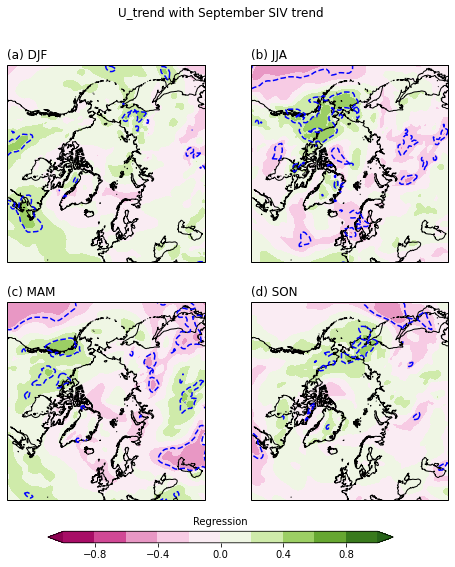

V_trend


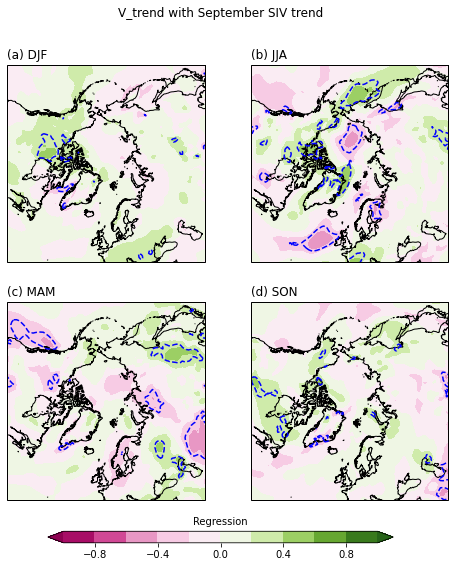

windspeed_trend


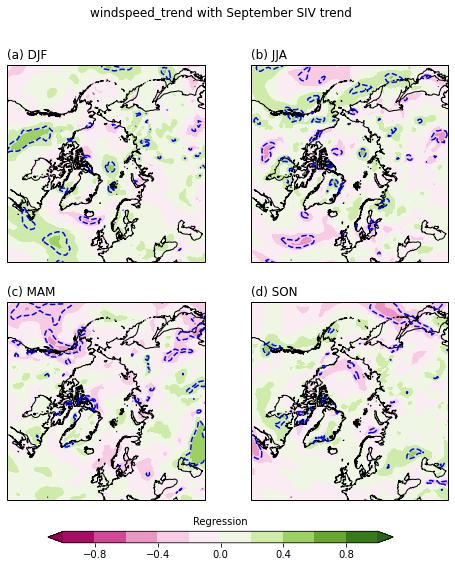

T200_trend


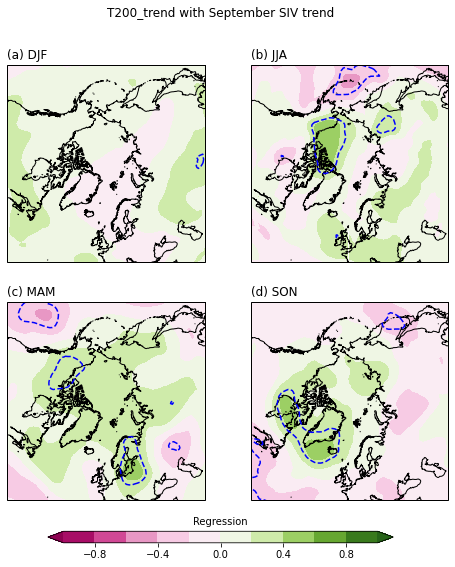

T500_trend


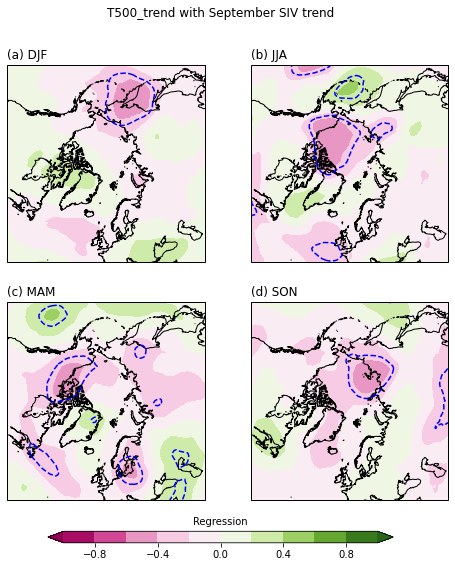

Z200_trend


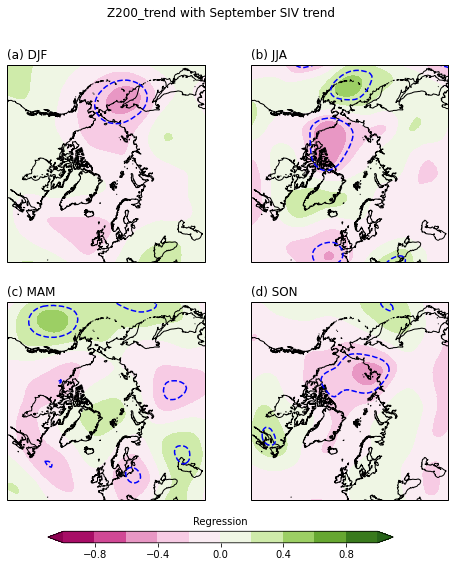

Z500_trend


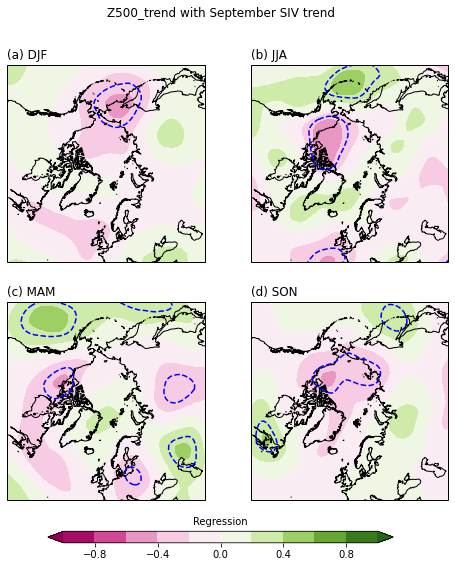

In [33]:
for var in ds:
    if 'trend' in var:
        print(var)
        xdata = ds[var].squeeze().sel(names = [f for f in ds.names.values if 'LEN' in f and 'mean' not in f])
        xdata = xdata.where(xdata==xdata,0.)
        corr, pval = myf.pearson(xdata, lens_siv_trend_sep, 'names')

        fig = plt.figure(figsize=(8,8))

        for s, seas in enumerate(ds.season.values):
            ax = plt.subplot(2,2,1+s, projection = ccrs.NorthPolarStereo())
            ax.set_extent([0.005, 360, 45, 90], crs=ccrs.PlateCarree())
            ax.coastlines("50m")  
            CS1 = ax.contourf(ds.lon,ds.lat, corr.sel(season=seas) ,
                          transform=ccrs.PlateCarree(), cmap = plt.cm.PiYG, extend='both',
                         levels = np.arange(-1,1.2,.2))

            ax.contour(ds.lon,ds.lat, pval.sel(season=seas) ,
                          transform=ccrs.PlateCarree(), levels=[.05], colors=['b'],linestyles=['--'])

            ax.set_title(myf.alphabet[s]+' '+seas,loc='left')
        cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02]) #[left, bottom, width, height]
        cbar = fig.colorbar(CS1, cax=cbar_ax,  orientation='horizontal')
        cbar.ax.set_title('Regression',fontsize=10)
        plt.suptitle(var+' with September SIV trend')
        plt.tight_layout()
        fig.savefig('figs/regression_'+var+'_SIV.pdf', dpi=500, bbox_inches='tight')
        plt.show()
        plt.close()